In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

In [2]:
path = os.getcwd()+"/data"

# initilize dataframe by benchmark
data = pd.read_csv(path+"/SPY.csv")
data = data.loc[:,["Adj Close","Date"]]
data.columns=["SPY","Date"]

#get all adj_close and inner join
ticker = ["FXE","EWJ","GLD","QQQ","SHV","DBA","USO","XBI","ILF","GAF","EPP","FEZ"]

for i in ticker:
    adj_close = pd.read_csv(path+"/{}.csv".format(i))
    adj_close = adj_close.loc[:,["Adj Close","Date"]]
    adj_close.columns=[i,"Date"]
    data = pd.merge(data,adj_close,how="inner",on="Date")
    
data.Date = pd.to_datetime(data.Date)
#import factors's data
factors = pd.read_csv(path+"/F-F_Research_Data_Factors_daily.CSV",
                      skiprows=5,
                      header=None,
                      names=["Date","Mkt-RF","SMB","HML","RF"])
factors = factors.iloc[:-1,:]
factors.Date = pd.to_datetime(factors["Date"],format="%Y%m%d")
data = pd.merge(data,factors,how="inner",on="Date")

data.set_index("Date",inplace=True)
data = data.drop(data.index[data["GAF"]=="null"])
data = data.applymap(float)
data.to_csv(os.getcwd()+"/data/adj_close.csv")

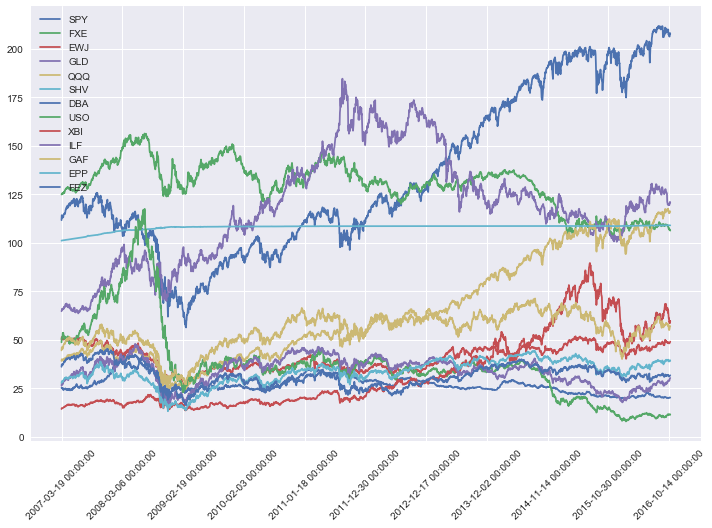

In [3]:
#plot the price first

plt.figure(figsize=(12,8))
plt.plot(data.SPY.values,label="SPY")
for i in ticker:
    plt.plot(data[i].values,label=i)
plt.legend()
plt.xticks(range(0,len(data),len(data)//10),data.index[range(0,len(data),len(data)//10)],rotation=45)
plt.show()

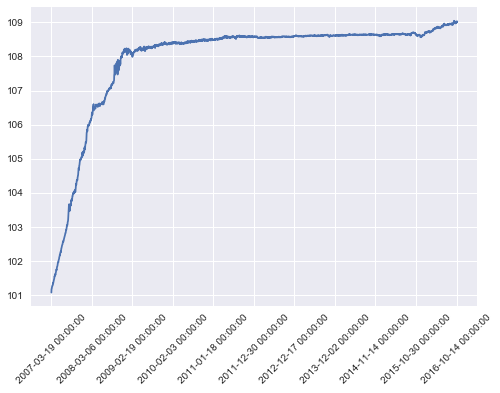

In [4]:
#plot SHV
plt.plot(data["SHV"].values)
plt.xticks(range(0,len(data),len(data)//10),data.index[range(0,len(data),len(data)//10)],rotation=45)
plt.show()

"SHV" stands for iShares Lehman Short Treasury Bond ETF. So unlike other ETFs, its volatility is very small relatively.

In [16]:
from sklearn.linear_model import LinearRegression
from cvxopt import solvers
from cvxopt import matrix
from scipy.stats import norm

class factor_model():
    
    def __init__(self,data,window,lamb_da):
        self.data = data
        self.window = window
        self.lamb_da = lamb_da
    
    def find_data(self, start, end):
        """
        find data in our dataset between a given period
        
        args:
            start,end: pd.datatime
            
        return:
            subset of our data
            
        """
        while not (start in self.data.index):
            start = start+pd.Timedelta(1,unit="d")
        
        #exclude end
        end = end-pd.Timedelta(1,unit="d")
        while not (end in self.data.index):
            end = end-pd.Timedelta(1,unit="d")
        
        return self.data.loc[start:end,:]
    
    def estimation(self,start):
        """
        estimate mu and Q in a certain period
        
        args:
            start: pd.datetime
            window: int, length of the window
        
        return:
            beta:
            mu:
            Q:
        """
        end = start+pd.Timedelta(self.window,unit="d")
        subset = self.find_data(start,end)
        #print(len(subset))
        ETFs = subset.iloc[:,:-4]
        factors = subset.iloc[1:,-4:]
        
        # calculate daily returns, including benchmark
        re_turn = (1-ETFs.shift()/ETFs).dropna()
        assert sum(factors.index != re_turn.index) == 0
        
        # calculate expected returns, without benchmark
        self.mu = re_turn.mean()[1:].values
        
        # calculate betas according to CAPM
        beta = []
        for i in range(1,len(ETFs.columns)):
            lr = LinearRegression()
            #fit benchmark to i-th ETF's excess return
            lr.fit(re_turn.iloc[:,0].values.reshape(-1,1),
                   (re_turn.iloc[:,i]-factors.loc[:,"RF"]).values.reshape(-1,1))
            beta.append(float(lr.coef_))
        self.beta = np.array(beta)
        
        # estimate covariance matrix according to FF-3 factors model
        B = np.zeros((len(ETFs.columns)-1,3))
        D = []
        for i in range(1,len(ETFs.columns)):
            lr = LinearRegression()
            #fit factors' data to i-th ETF's excess return
            x = factors.iloc[:,:-1].values
            y = (re_turn.iloc[:,i]-factors.loc[:,"RF"]).values.reshape(-1,1)
            lr.fit(x,y)
            y_hat = lr.predict(x)
            
            D.append((y-y_hat).std()**2)     
            B[i-1,:] = lr.coef_
        
        D = np.diagflat(D)
        
        #covariance matrix of factors
        cov = factors.iloc[:,:-1].cov()
        
        #calculate Q
        self.Q = B@cov@B.T+D
        

    
    def initialize_benchmark_weights(self):
        # solve the benchmark optimization problem
        # self.weights 
        
        n=len(self.mu)
        #minimize
        P=matrix(self.Q+self.lamb_da*np.eye(n))
        # W_p for initial benchmark problem is equal weights
        q=matrix(-self.lamb_da*np.ones(n)/n)
        
        #equal constraint: sum of xi's equals 1
        A=matrix(np.row_stack((np.ones(n),self.mu)))
        b=matrix([1.0,0.15/250])
        #inequal constraint: -2<=xi<=2
        G=np.vstack((np.eye(n),-np.eye(n)))
        G=matrix(G)
        h=matrix([2.0 for i in range(2*n)])

        solvers.options['show_progress'] = False
        sol=solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

        self.bench_weights = np.array(sol["x"]).ravel()
        return np.array(sol["x"]).ravel()
    
    def bench_weights_update(self):
        n=len(self.mu)
        #minimize
        P=matrix(self.Q+self.lamb_da*np.eye(n))
        # W_p for initial benchmark problem is equal weights
        q=matrix(-self.lamb_da*self.bench_weights)
        
        #equal constraint: sum of xi's equals 1
        A=matrix(np.row_stack((np.ones(n),self.mu)))
        b=matrix([1.0,0.15/250])
        #inequal constraint: -2<=xi<=2
        G=np.vstack((np.eye(n),-np.eye(n)))
        G=matrix(G)
        h=matrix([2.0 for i in range(2*n)])

        solvers.options['show_progress'] = False
        sol=solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

        self.bench_weights = np.array(sol["x"]).ravel()
        return np.array(sol["x"]).ravel()        

    def weights_update(self,target_beta):
        
        #after update our estimation for mu and Q, we update portfolio weights

        n=len(self.mu)
        
        #minimize
        P=matrix(2*self.lamb_da*np.eye(n))
        # W_p for updating problem is previous weights
        q=matrix(-2*self.lamb_da*self.weights-self.mu)
        
        #equal constraint: sum of xi's equals 1
        A=matrix(np.row_stack((np.ones(n),self.beta)))
        b=matrix([1.0,target_beta])
        #inequal constraint: -2<=xi<=2
        G=np.vstack((np.eye(n),-np.eye(n)))
        G=matrix(G)
        h=matrix([2.0 for i in range(2*n)])

        solvers.options['show_progress'] = False
        sol=solvers.qp(P=P,q=q,G=G,h=h,A=A,b=b)

        self.weights = np.array(sol["x"]).ravel()
        #return np.array(sol["x"])      
                    
        
    def backtest(self,target_beta,rebalancing_period=20,do_plot=False):
        
        ndays = (self.data.index[-1]-self.data.index[0]).days
        n = (ndays-self.window)//rebalancing_period
        end = [self.data.index[-1]-pd.Timedelta(i*rebalancing_period,unit="d") for i in range(n)][::-1]
        mid = [i-pd.Timedelta(rebalancing_period,unit="d") for i in end]
        start = [i-pd.Timedelta(self.window,unit="d") for i in mid]
        assert start[-1]>=self.data.index[0]
        
        # initialize
        self.estimation(start[0])
        self.weights = self.initialize_benchmark_weights()
        
        # 1st portfolio
        subset = self.find_data(mid[0],end[0]).iloc[:,1:-4]
        portfolio = subset.values@np.column_stack((self.weights,self.bench_weights))
        value = pd.DataFrame(portfolio,columns = ["portfolio","Min_vol"],index=subset.index)

        
        for i in range(1,len(start)):
            self.estimation(start[i])
            
            self.weights_update(target_beta)
            cache = self.bench_weights_update()
            #print(self.bench_weights@self.mu)    all = 0.006
            #print(self.weights)
            subset = self.find_data(mid[i],end[i]).iloc[:,1:-4]
            portfolio = subset.values@np.column_stack((self.weights,self.bench_weights))
            a = pd.DataFrame(portfolio,columns = ["portfolio","Min_vol"],index=subset.index)
            #each time we rebalance our portfolio, we should have some cash in/out, so we adjust portfolio price
            a.portfolio = a.portfolio-(a.portfolio.iloc[0]-value.portfolio.iloc[-1])
            a.Min_vol = a.Min_vol-(a.Min_vol.iloc[0]-value.Min_vol.iloc[-1])
            value = value.append(a)
        
        
        #now we get price series of portfolio and each ETF
        value = value.join(self.data.iloc[:,:-4],how="inner")
        
        #suppose we buy 100$ at the beginning
        shares = 100/value.iloc[0,:]
        pnl = shares*(value - value.shift()).dropna()
        
        #1. daily cumsum pnl
        cum_pnl = pnl.cumsum()
        final_pnl = cum_pnl.iloc[-1,:]
        
        figs=[]
        f1 = plt.figure()
        plt.plot(cum_pnl.portfolio,label="porfolio_"+str(target_beta))
        plt.plot(cum_pnl.SPY,label="SNP500")
        plt.plot(cum_pnl.Min_vol,label="Min vol")
        plt.legend()
        plt.title("PnL")
        figs.append(f1)
        """
        plt.figure(figsize=(12,8))
        for i in range(pnl.shape[1]):
            plt.plot(pnl.cumsum().iloc[:,i],label=pnl.columns[i])
        plt.legend()
        plt.xticks(rotation=45)
        """
        
        
        # daily return 
        re_turn = (value/value.shift()-1).dropna()
        
        # distplot
        if do_plot == True:
            fig2, ax = plt.subplots(nrows=5, ncols=3,figsize=(12,8))
            num=0
            title =list(re_turn.columns)
            plt.tight_layout()
            for row in range(5):
                for col in range(3):
                    sns.distplot(re_turn.iloc[:,num], ax=ax[row, col])
                    plt.title(title[num])
                    num+=1
                    if num == 14:
                        break
            figs.append(fig2)


        #2. (annualized) Daily Mean Geometric Return
        DMGR = ((re_turn+1).prod()**(1/len(re_turn))-1)*250
        
        #3. (annualized) Daily Min Return
        DMinR = (re_turn.min())*250
        
        #4. Max 10 days Drawdown
        daily_rolling_drawdown = value/value.rolling(window=10,min_periods=1,center=False).max()-1
        M10DD = daily_rolling_drawdown.rolling(window=10,min_periods=1,center=False).min()
        M10DD = -M10DD.min()
        
        
        #5. annualized volatility
        vol = (value/value.shift()-1).dropna().std()
        annualized_vol = vol*np.sqrt(250)
        
        #6. Sharpe ratio
        sharpe = (re_turn.mean()*250-self.data.loc[:,"RF"].values.mean())/annualized_vol
        
        #7. Skewness
        s = re_turn.skew()
        
        #8. Kurtosis
        k = re_turn.kurt()
        
        #9. Modified VaR
        z=0.95
        M_Var = (re_turn.mean()+(z+(z**2+1)*s/6+(z**3-3*z)*k/24-(2*z**3-5*z)*s**2/36)*vol)*250
        
        #10. CVaR
        alpha = 1-z
        CVaR = (alpha**(-1)*norm.pdf(norm.ppf(alpha))*vol-re_turn.mean())*250
        
        mat1 = np.row_stack((final_pnl,DMGR,DMinR,M10DD,annualized_vol,sharpe,s,k,M_Var,CVaR))
        column = list(re_turn.columns[1:])
        column.insert(0,"portfolio_"+str(target_beta))
        summary1 = pd.DataFrame(mat1,columns=column,index=["cumulative pnl",
                                                                  "Daily Mean Geometric Return",
                                                                 "Daily Min Return",
                                                                 "Max 10 days Drawdown",
                                                                 "volatility",
                                                                 " Sharpe ratio",
                                                                 "Skewness",
                                                                 "Kurtosis",
                                                                 "Modified VaR","CVaR"])
        return summary1, figs
        

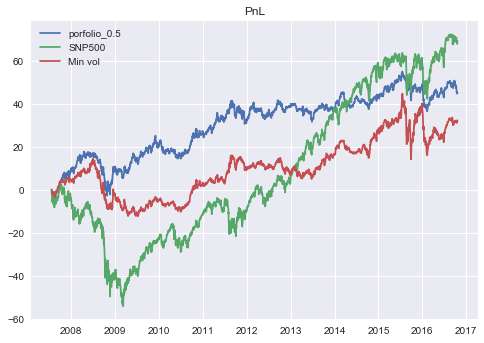

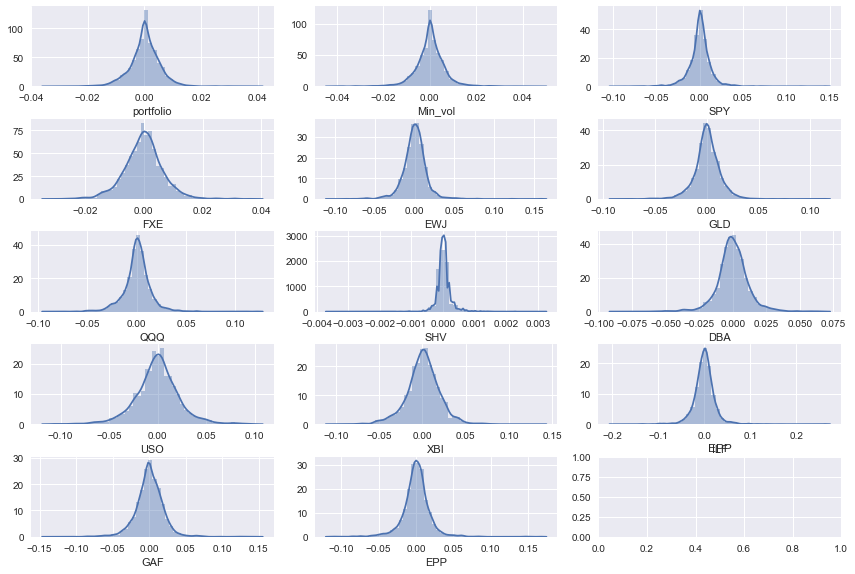

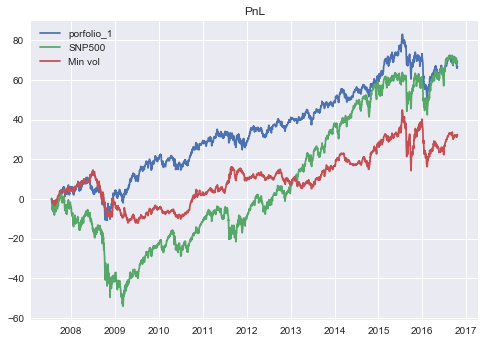

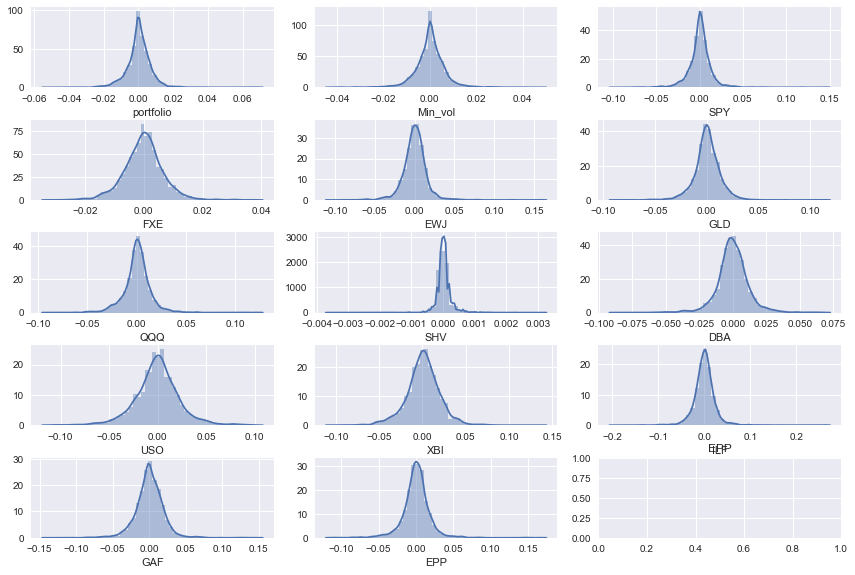

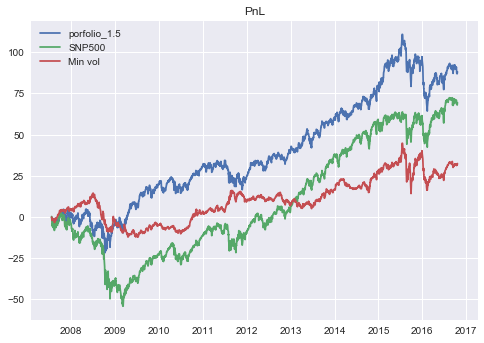

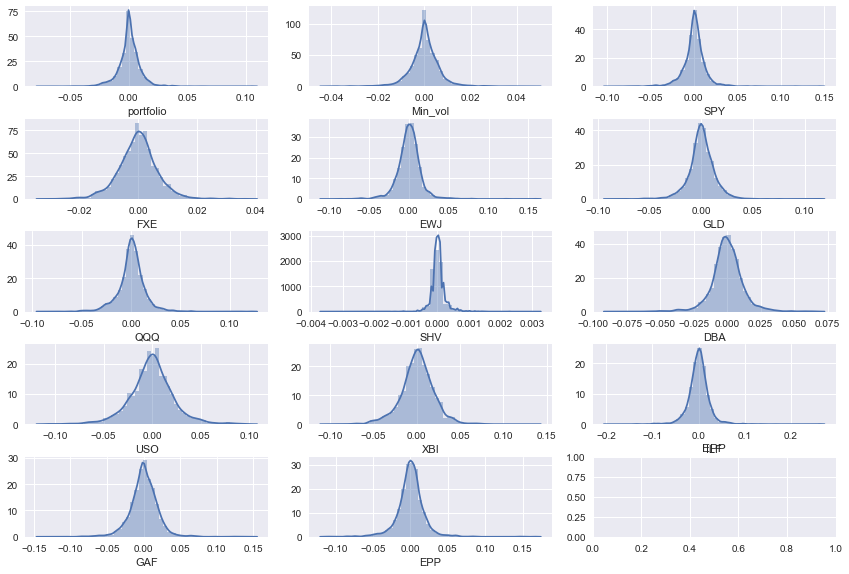

In [17]:
summary_list=[]
for i in [0.5,1,1.5]:
    model = factor_model(data,120,2)
    results,figs = model.backtest(i,do_plot=True)
    summary_list.append(results.applymap(lambda x: round(x,4)))
    plt.show(figs[0])
    plt.show(figs[1])

In [18]:
display(summary_list[0])
display(summary_list[1])
display(summary_list[2])

,portfolio_0.5,Min_vol,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ
cumulative pnl,45.2729,32.4592,69.4782,-18.6970,-3.6165,79.2098,156.7866,6.0329,-20.6229,-79.5439,263.1139,-14.6122,12.1362,19.7297,-24.8783
Daily Mean Geometric Return,0.0401,0.0302,0.0566,-0.0222,-0.0040,0.0626,0.1012,0.0063,-0.0248,-0.1702,0.1384,-0.0169,0.0123,0.0193,-0.0307
Daily Min Return,-8.3091,-10.4487,-24.6120,-7.6873,-26.0193,-21.9521,-22.3891,-0.9050,-21.5149,-26.7114,-25.2530,-48.6667,-34.0566,-28.0545,-30.5293
Max 10 days Drawdown,0.0729,0.1388,0.2495,0.0814,0.2411,0.2023,0.2327,0.0036,0.2282,0.2490,0.2470,0.3833,0.2731,0.3041,0.2699
volatility,0.0866,0.1023,0.2136,0.1051,0.2358,0.1996,0.2207,0.0040,0.1929,0.3588,0.3038,0.3655,0.3107,0.2960,0.3138
Sharpe ratio,0.4798,0.3237,0.3610,-0.1806,0.0911,0.4021,0.5584,0.9953,-0.0437,-0.3011,0.6000,0.1297,0.1876,0.2053,0.0517
Skewness,0.0051,-0.1300,0.2186,0.0995,0.4187,-0.0619,0.0873,-0.3180,-0.2074,-0.0049,-0.0582,0.3937,0.0577,0.2640,0.1483
Kurtosis,4.2865,6.3200,13.5175,2.1871,11.3917,6.2321,7.3485,40.0314,5.4409,2.1267,2.3876,13.7766,6.8596,9.2899,7.5568
Modified VaR,0.8592,0.6588,-0.2547,1.3136,0.5895,1.3865,1.4106,-0.1507,1.3240,4.2736,3.7088,-0.2735,2.0210,1.3186,1.8616
CVaR,2.7793,3.3007,6.8857,3.4432,7.6667,6.4257,7.0734,0.1250,6.2972,11.8087,9.7245,11.8714,10.0728,9.5905,10.2160


,portfolio_1,Min_vol,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ
cumulative pnl,66.6806,32.4592,69.4782,-18.6970,-3.6165,79.2098,156.7866,6.0329,-20.6229,-79.5439,263.1139,-14.6122,12.1362,19.7297,-24.8783
Daily Mean Geometric Return,0.0548,0.0302,0.0566,-0.0222,-0.0040,0.0626,0.1012,0.0063,-0.0248,-0.1702,0.1384,-0.0169,0.0123,0.0193,-0.0307
Daily Min Return,-13.0086,-10.4487,-24.6120,-7.6873,-26.0193,-21.9521,-22.3891,-0.9050,-21.5149,-26.7114,-25.2530,-48.6667,-34.0566,-28.0545,-30.5293
Max 10 days Drawdown,0.1022,0.1388,0.2495,0.0814,0.2411,0.2023,0.2327,0.0036,0.2282,0.2490,0.2470,0.3833,0.2731,0.3041,0.2699
volatility,0.1100,0.1023,0.2136,0.1051,0.2358,0.1996,0.2207,0.0040,0.1929,0.3588,0.3038,0.3655,0.3107,0.2960,0.3138
Sharpe ratio,0.5325,0.3237,0.3610,-0.1806,0.0911,0.4021,0.5584,0.9953,-0.0437,-0.3011,0.6000,0.1297,0.1876,0.2053,0.0517
Skewness,0.1527,-0.1300,0.2186,0.0995,0.4187,-0.0619,0.0873,-0.3180,-0.2074,-0.0049,-0.0582,0.3937,0.0577,0.2640,0.1483
Kurtosis,7.8532,6.3200,13.5175,2.1871,11.3917,6.2321,7.3485,40.0314,5.4409,2.1267,2.3876,13.7766,6.8596,9.2899,7.5568
Modified VaR,0.6668,0.6588,-0.2547,1.3136,0.5895,1.3865,1.4106,-0.1507,1.3240,4.2736,3.7088,-0.2735,2.0210,1.3186,1.8616
CVaR,3.5270,3.3007,6.8857,3.4432,7.6667,6.4257,7.0734,0.1250,6.2972,11.8087,9.7245,11.8714,10.0728,9.5905,10.2160


,portfolio_1.5,Min_vol,SPY,FXE,EWJ,GLD,QQQ,SHV,DBA,USO,XBI,ILF,GAF,EPP,FEZ
cumulative pnl,88.0883,32.4592,69.4782,-18.6970,-3.6165,79.2098,156.7866,6.0329,-20.6229,-79.5439,263.1139,-14.6122,12.1362,19.7297,-24.8783
Daily Mean Geometric Return,0.0678,0.0302,0.0566,-0.0222,-0.0040,0.0626,0.1012,0.0063,-0.0248,-0.1702,0.1384,-0.0169,0.0123,0.0193,-0.0307
Daily Min Return,-18.6652,-10.4487,-24.6120,-7.6873,-26.0193,-21.9521,-22.3891,-0.9050,-21.5149,-26.7114,-25.2530,-48.6667,-34.0566,-28.0545,-30.5293
Max 10 days Drawdown,0.1379,0.1388,0.2495,0.0814,0.2411,0.2023,0.2327,0.0036,0.2282,0.2490,0.2470,0.3833,0.2731,0.3041,0.2699
volatility,0.1551,0.1023,0.2136,0.1051,0.2358,0.1996,0.2207,0.0040,0.1929,0.3588,0.3038,0.3655,0.3107,0.2960,0.3138
Sharpe ratio,0.4998,0.3237,0.3610,-0.1806,0.0911,0.4021,0.5584,0.9953,-0.0437,-0.3011,0.6000,0.1297,0.1876,0.2053,0.0517
Skewness,0.1696,-0.1300,0.2186,0.0995,0.4187,-0.0619,0.0873,-0.3180,-0.2074,-0.0049,-0.0582,0.3937,0.0577,0.2640,0.1483
Kurtosis,10.9719,6.3200,13.5175,2.1871,11.3917,6.2321,7.3485,40.0314,5.4409,2.1267,2.3876,13.7766,6.8596,9.2899,7.5568
Modified VaR,0.3134,0.6588,-0.2547,1.3136,0.5895,1.3865,1.4106,-0.1507,1.3240,4.2736,3.7088,-0.2735,2.0210,1.3186,1.8616
CVaR,4.9789,3.3007,6.8857,3.4432,7.6667,6.4257,7.0734,0.1250,6.2972,11.8087,9.7245,11.8714,10.0728,9.5905,10.2160


In [19]:
Summary2 = pd.concat((summary_list[0].iloc[:,0],summary_list[1].iloc[:,0],summary_list[2].iloc[:,:3]), axis =1)
display(Summary2)

,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,45.2729,66.6806,88.0883,32.4592,69.4782
Daily Mean Geometric Return,0.0401,0.0548,0.0678,0.0302,0.0566
Daily Min Return,-8.3091,-13.0086,-18.6652,-10.4487,-24.6120
Max 10 days Drawdown,0.0729,0.1022,0.1379,0.1388,0.2495
volatility,0.0866,0.1100,0.1551,0.1023,0.2136
Sharpe ratio,0.4798,0.5325,0.4998,0.3237,0.3610
Skewness,0.0051,0.1527,0.1696,-0.1300,0.2186
Kurtosis,4.2865,7.8532,10.9719,6.3200,13.5175
Modified VaR,0.8592,0.6668,0.3134,0.6588,-0.2547
CVaR,2.7793,3.5270,4.9789,3.3007,6.8857


In [20]:
def summary_without_distplot(data,look_back,dataname):
    summ = []
    for i in [0.5,1,1.5]:
        model = factor_model(data,look_back,2)
        fig = plt.figure(i)
        results,fig = model.backtest(i)
        summ.append(results.applymap(lambda x: round(x,4)))
        plt.savefig(dataname+str(i)+str(look_back)+".png")
    Summary2 = pd.concat((summ[0].iloc[:,0],summ[1].iloc[:,0],summ[2].iloc[:,:3]), axis =1)
    return Summary2

In [21]:
# we split the data by the end of 2009
crisis = data.loc[:'2009-12-31']
post_crisis = data.loc['2010-01-04':]
dictionary = {"crisis":crisis,"post_crisis":post_crisis}

summary = []

for i in dictionary:
    for j in [60,120,200]:
        a= summary_without_distplot(dictionary[i],j,i)
        summary.append(a)
        


Results for crisis data with lookback=60


,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,9.7860,1.0115,-7.7629,22.8509,-22.0815
Daily Mean Geometric Return,0.0360,0.0039,-0.0311,0.0793,-0.0961
Daily Min Return,-8.7349,-13.8435,-23.0012,-6.7054,-24.6120
Max 10 days Drawdown,0.0977,0.1315,0.1794,0.0467,0.2495
volatility,0.1293,0.1746,0.2698,0.0989,0.3179
Sharpe ratio,0.2863,0.0675,-0.0076,0.7774,-0.1671
Skewness,-0.0229,0.0121,0.0189,-0.0191,0.4096
Kurtosis,3.1194,5.0959,6.9683,1.0941,8.1774
Modified VaR,1.4420,1.4841,1.6154,1.4179,2.0403
CVaR,4.1719,5.6744,8.7936,3.1405,10.4123


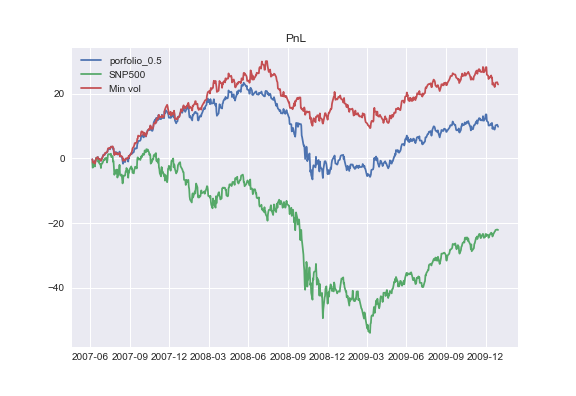

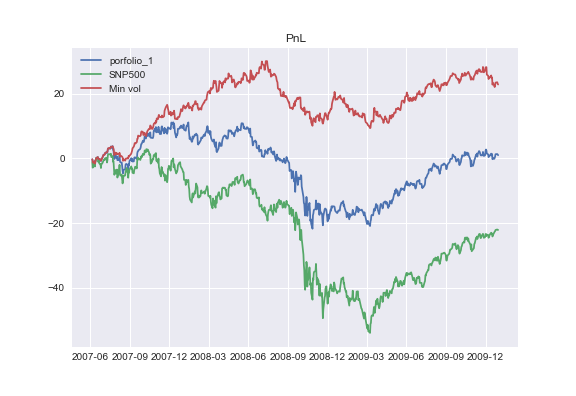

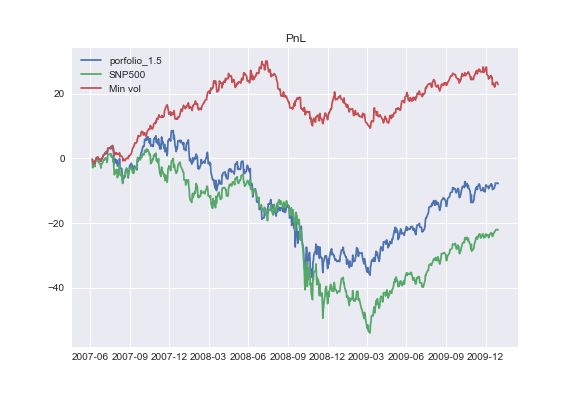



Results for crisis data with lookback=120


,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,12.8000,5.9060,-0.9880,-6.0172,-18.5529
Daily Mean Geometric Return,0.0497,0.0237,-0.0041,-0.0256,-0.0846
Daily Min Return,-10.5833,-16.1446,-23.7875,-7.8743,-24.6120
Max 10 days Drawdown,0.1172,0.1533,0.2015,0.0779,0.2495
volatility,0.1553,0.1952,0.2845,0.1301,0.3257
Sharpe ratio,0.3505,0.1814,0.1020,-0.1880,-0.1202
Skewness,-0.0482,-0.0799,0.0415,0.3389,0.4063
Kurtosis,2.1209,4.6452,6.4030,2.0285,7.8403
Modified VaR,1.9254,1.7081,1.9781,1.8320,2.2435
CVaR,5.0042,6.3242,9.2418,4.2613,10.6556


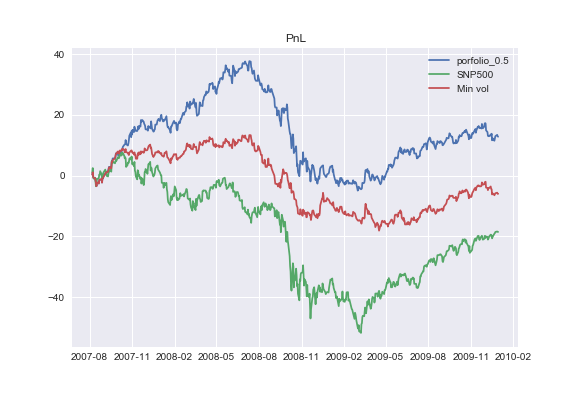

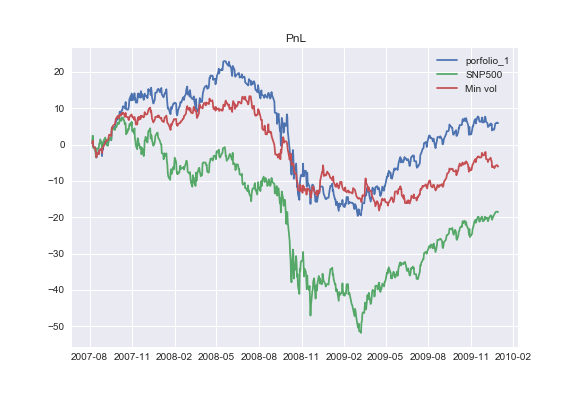

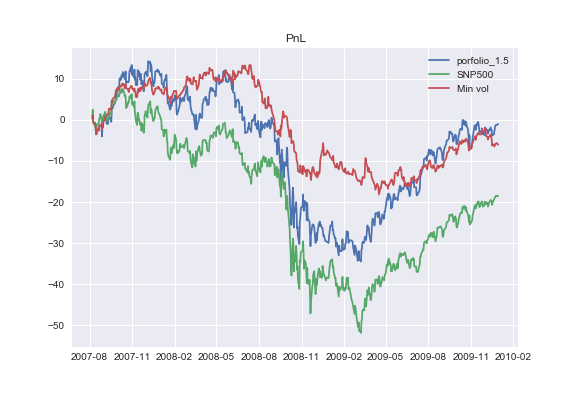



Results for crisis data with lookback=200


,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,-0.1341,-3.4710,-6.8079,-25.6919,-21.9020
Daily Mean Geometric Return,-0.0006,-0.0160,-0.0320,-0.1347,-0.1121
Daily Min Return,-9.1042,-14.7460,-21.9005,-10.2685,-24.6120
Max 10 days Drawdown,0.1008,0.1344,0.1839,0.1461,0.2495
volatility,0.1341,0.1810,0.2694,0.2108,0.3373
Sharpe ratio,0.0079,-0.0387,-0.0117,-0.5688,-0.1863
Skewness,0.1514,0.3317,0.3562,0.2999,0.4174
Kurtosis,3.7784,6.4817,7.8436,2.1023,7.3591
Modified VaR,1.4633,1.5067,1.8036,2.8136,2.5368
CVaR,4.3649,5.9038,8.7828,6.9861,11.0572


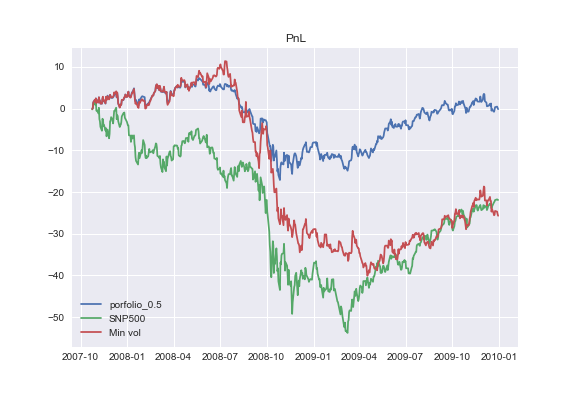

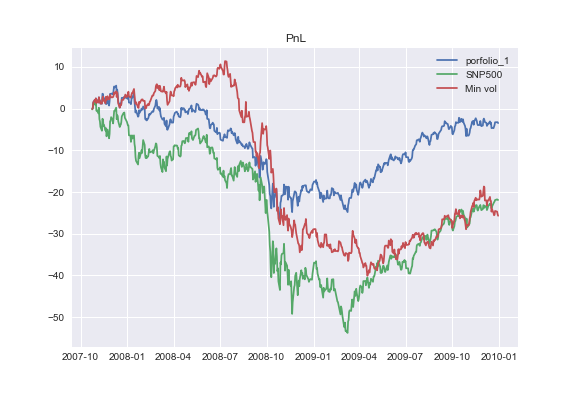

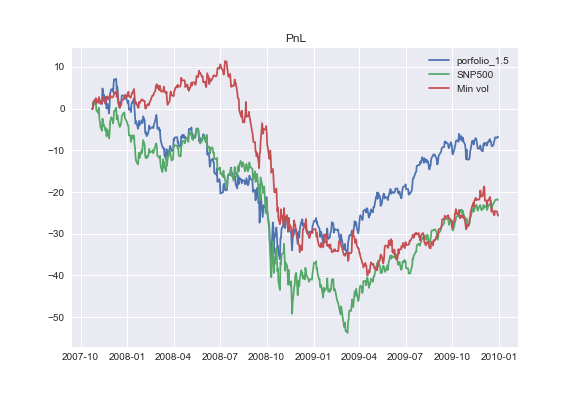



Results for post_crisis data with lookback=60


,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,38.6084,58.7469,78.8855,37.1969,115.1133
Daily Mean Geometric Return,0.0489,0.0693,0.0872,0.0474,0.1148
Daily Min Return,-4.6198,-6.8407,-9.3038,-7.8621,-16.2808
Max 10 days Drawdown,0.0696,0.0940,0.1146,0.0873,0.1580
volatility,0.0798,0.1064,0.1373,0.0889,0.1552
Sharpe ratio,0.6506,0.7023,0.7019,0.5750,0.8164
Skewness,-0.2520,-0.2242,-0.1701,-0.4046,-0.3581
Kurtosis,1.3046,1.6592,2.1959,4.8572,3.9318
Modified VaR,1.0196,1.3286,1.6515,0.6591,1.4046
CVaR,2.5493,3.3942,4.3817,2.8487,4.9333


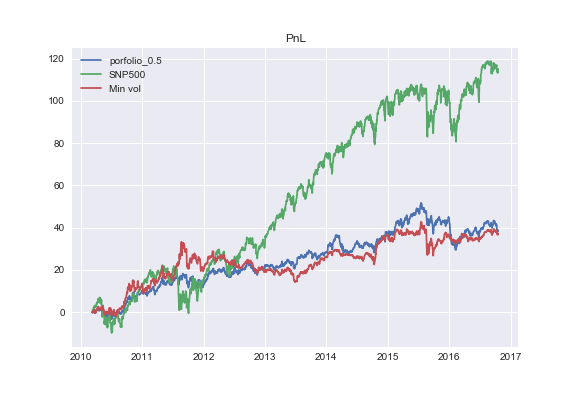

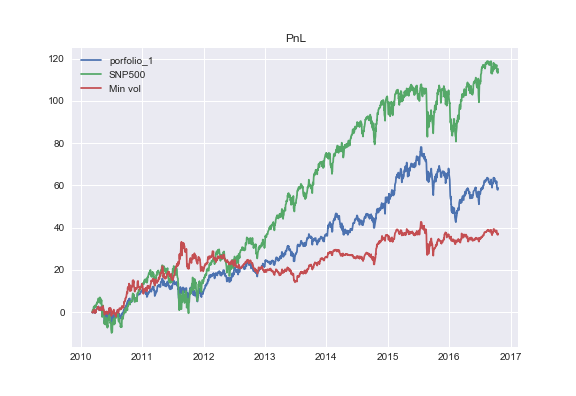

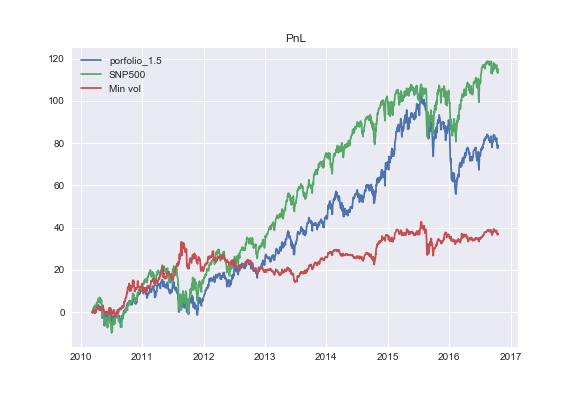



Results for post_crisis data with lookback=120


,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,42.8835,59.1893,75.4951,57.6782,109.5547
Daily Mean Geometric Return,0.0548,0.0714,0.0864,0.0700,0.1137
Daily Min Return,-8.6918,-6.4859,-9.0989,-9.8609,-16.2808
Max 10 days Drawdown,0.0704,0.0860,0.1030,0.1217,0.1580
volatility,0.0953,0.1043,0.1292,0.1099,0.1557
Sharpe ratio,0.6206,0.7349,0.7317,0.6899,0.8068
Skewness,-0.4141,-0.2200,-0.1567,-0.2476,-0.3425
Kurtosis,2.1374,1.4809,1.8667,5.6142,3.9493
Modified VaR,1.0477,1.3326,1.6220,0.7891,1.4142
CVaR,3.0496,3.3250,4.1201,3.5069,4.9516


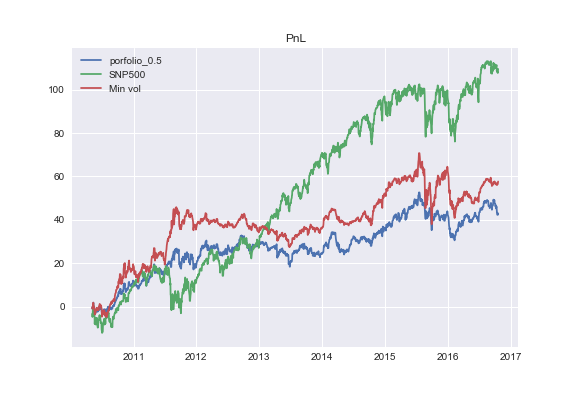

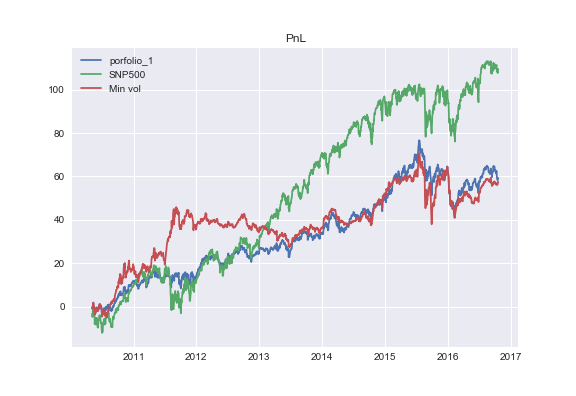

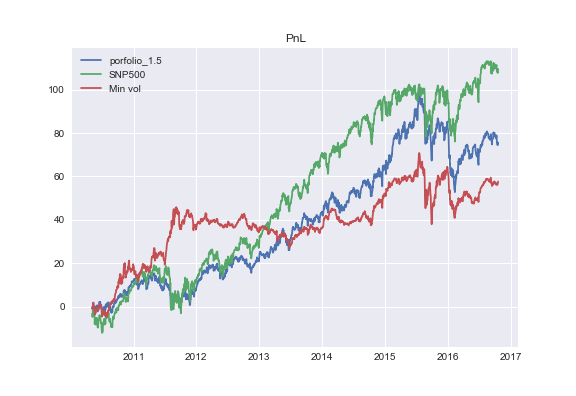



Results for post_crisis data with lookback=200


,portfolio_0.5,portfolio_1,portfolio_1.5,Min_vol,SPY
cumulative pnl,42.8783,50.8950,58.9117,38.4797,118.3960
Daily Mean Geometric Return,0.0568,0.0655,0.0737,0.0518,0.1243
Daily Min Return,-10.6591,-8.0117,-8.4109,-8.4399,-16.2808
Max 10 days Drawdown,0.0661,0.0716,0.0880,0.0954,0.1580
volatility,0.0911,0.0928,0.1058,0.0936,0.1501
Sharpe ratio,0.6664,0.7496,0.7476,0.5979,0.9019
Skewness,-0.5423,-0.3247,-0.2121,-0.4560,-0.4003
Kurtosis,3.8696,2.5703,2.3488,4.9823,4.1750
Modified VaR,0.7547,1.0125,1.2361,0.6620,1.2986
CVaR,2.9105,2.9564,3.3710,2.9968,4.7604


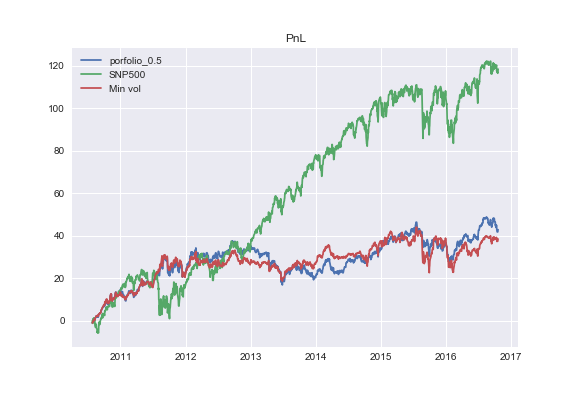

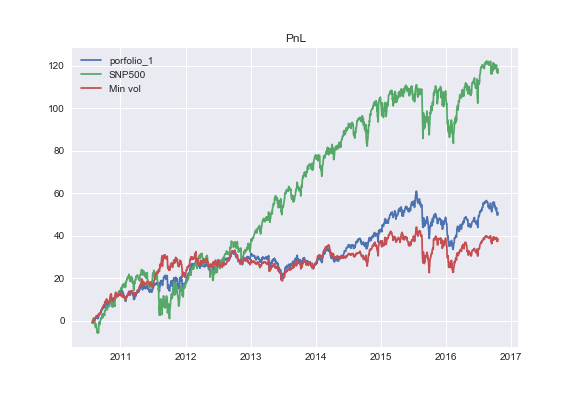

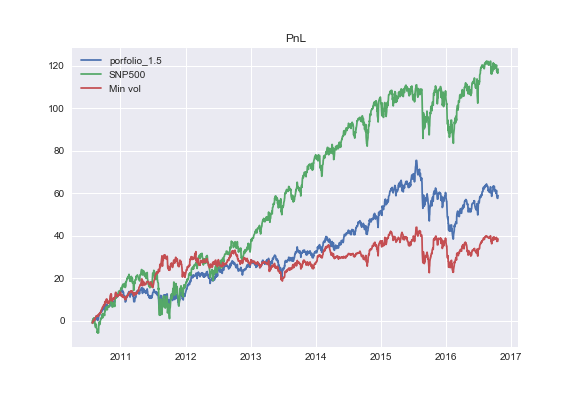

In [33]:
from IPython.display import Image

l=[]
for i in ["crisis","post_crisis"]:
    for j in [60,120,200]:
        l.append((i,j))
        
for i in range(6):
    print("Results for {} data with lookback={}".format(l[i][0],l[i][1]))
    display(summary[i])
    for j in [0.5,1,1.5]:
        file = l[i][0]+str(j)+str(l[i][1])+".png"
        display(Image(filename = file))
    print("\n")
        